In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Packages

In [ ]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries


import gc; gc.enable()
from skimage.morphology import label
from sklearn.model_selection import train_test_split

In [ ]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '/content/drive/MyDrive/DATA_255/LAB1_part3'
train_image_dir = '/content/drive/MyDrive/DATA_255/LAB1_part3/input_dir/Train Image1/TI/train images 1'#os.path.join(ship_dir, '/Train Image1/TI/train images 1')
test_image_dir = os.path.join('/content/drive/MyDrive/DATA_255/LAB1_part3/input_dir/Test Image/untitled folder/test images 2')

## Model Parameters
We might want to adjust these later (or do some hyperparameter optimizations)

In [ ]:
BATCH_SIZE = 48
NB_EPOCHS = 40
VALID_IMG_COUNT = 900
MAX_TRAIN_STEPS = 9
IMG_SCALING = (3, 3)
BATCH_NORMALIZATION = None
AUGMENT_BRIGHTNESS = False
SEED = None

In [ ]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    all_masks = np.zeros((768, 768), dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [ ]:
masks = pd.read_csv(os.path.join('/content/drive/MyDrive/DATA_255/LAB1_part3/input_dir/train_df.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

194608 masks found
161747


,Unnamed: 0,ImageId,EncodedPixels
0,0,00003e153.jpg,NaN
1,1,0001124c7.jpg,NaN
2,2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,3,0001b1832.jpg,NaN
4,4,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


# Make sure encode/decode works
Given the process
$$  RLE_0 \stackrel{Decode}{\longrightarrow} \textrm{Image}_0 \stackrel{Encode}{\longrightarrow} RLE_1 \stackrel{Decode}{\longrightarrow} \textrm{Image}_1 $$
We want to check if/that
$ \textrm{Image}_0 \stackrel{?}{=} \textrm{Image}_1 $
We could check the RLEs as well but that is more tedious. Also depending on how the objects have been labeled we might have different counts.



Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4


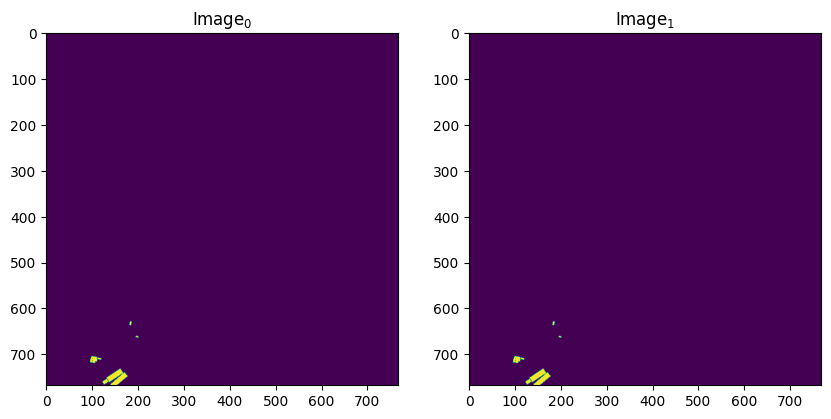

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

# Split into training and validation groups
We stratify by the number of boats appearing so we have nice balances in each set

In [ ]:
import os

masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

# filter out images not present in the directory
unique_img_ids = unique_img_ids[unique_img_ids['ImageId'].isin(os.listdir('/content/drive/MyDrive/DATA_255/LAB1_part3/input_dir/Train Image1/TI/train images 1'))]

# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id:
                                                               os.stat(os.path.join('/content/drive/MyDrive/DATA_255/LAB1_part3/input_dir/Train Image1/TI/train images 1',
                                                                                    c_img_id)).st_size/1024)
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
7018,0b0c3c929.jpg,0,0.0,[0.0],93.214844
103922,a484f9291.jpg,1,1.0,[1.0],135.487305
11128,119b33fd0.jpg,0,0.0,[0.0],95.026367
75405,774cf1a7b.jpg,0,0.0,[0.0],140.211914
76478,78f927e7b.jpg,0,0.0,[0.0],86.417969
64563,66350769c.jpg,0,0.0,[0.0],106.907227
85206,86edc7746.jpg,1,1.0,[1.0],146.298828


# Undersample Empty Images
Here we undersample the empty images to get a better balanced group with more ships to try and segment

5971 masks


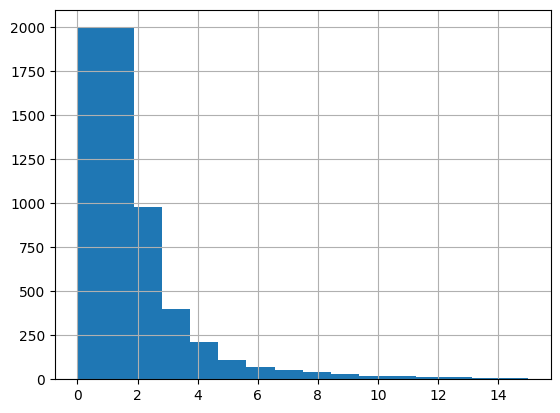

In [ ]:
SAMPLES_PER_GROUP = 2000
balanced_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_df['ships'].hist(bins=balanced_df['ships'].max()+1)
print(balanced_df.shape[0], 'masks')

In [ ]:
train_ids, valid_ids = train_test_split(balanced_df,
                 test_size = 0.2,
                 stratify = balanced_df['ships'],
                 random_state=SEED)
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

8682 training masks
2171 validation masks


### Examine Number of Ship Images
Here we examine how often ships appear and replace the ones without any ships with 0

<Axes: >

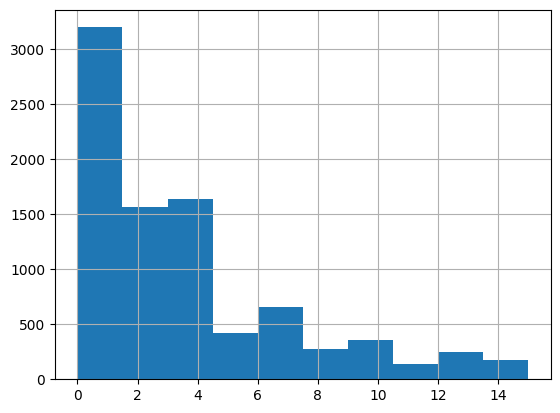

In [ ]:
train_df['ships'].hist()

Decode all the RLEs into Images


In [ ]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [ ]:
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0 1


# Make the Validation Set

In [ ]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(900, 256, 256, 3) (900, 256, 256, 1)


In [ ]:
gc.collect()

9007

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False,
                  samplewise_center = False,
                  rotation_range = 45,
                  width_shift_range = 0.1,
                  height_shift_range = 0.1,
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],
                  horizontal_flip = True,
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed=SEED):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x,
                             batch_size = in_x.shape[0],
                             seed = seed,
                             shuffle=True)
        g_y = label_gen.flow(in_y,
                             batch_size = in_x.shape[0],
                             seed = seed,
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

## Build Unet Model using ResNet50 as Encoder

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Conv2DTranspose, Concatenate, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, DenseNet121, DenseNet169

In [ ]:
def conv_block(inputs, no_filters):
    x = Conv2D(no_filters, 3, padding="same")(inputs)
    if BATCH_NORMALIZATION is not None:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(no_filters, 3, padding="same")(x)
    if BATCH_NORMALIZATION is not None:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip_features, no_filters):
    x = Conv2DTranspose(no_filters, (2, 2), strides=2, padding="same")(inputs)

    x = Concatenate(axis=3)([skip_features, x])
    x = conv_block(x, no_filters)
    return x

In [ ]:
def build_resnet50_unet(input_shape):
    """ Input """
    input_imgs = Input(input_shape, name = 'RGB_Input')

    """ Pretrained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=input_imgs)

#     resnet50.trainable = False

    """ Skip Features """
    e1 = input_imgs  # (265, 265, 3)
    e2 = resnet50.layers[4].output # (128, 128, 64)
    e3 = resnet50.layers[38].output # (64, 64, 265)
    e4 = resnet50.layers[80].output # (32, 32, 512)

    """ Bridge """
    b1 = resnet50.layers[142].output # (16, 16, 1024)

    """ Decoder """
    d1 = decoder_block(b1, e4, 512)
    d2 = decoder_block(d1, e3, 256)
    d3 = decoder_block(d2, e2, 128)
    d4 = decoder_block(d3, e1, 64)

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(input_imgs, outputs)
    return model

In [ ]:
model = build_resnet50_unet(train_x.shape[1:])
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 RGB_Input (InputLayer)      [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['RGB_Input[0][0]']           
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [ ]:
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

## intersection over union
def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def combo_loss(y_true, y_pred):
    return 1e-3 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def jaccard_index(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean((intersection + smooth) / (union + smooth), axis=0)

model.compile(optimizer=Adam(1e-3), loss=IoU, metrics=[dice_coef, 'binary_accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
model_dir='/content/seg_model.h5'  #use the model saved from the q3 part1
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

weight_path="{}_weights.best.hdf5".format(model_dir)

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=1,
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=1e-8)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      verbose = 2,
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('DICE')

    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    plt.savefig('losses.png')

show_loss(loss_history)

## Taking Insight about Training and Validation Results

In [ ]:
fig, m_axs = plt.subplots(20, 3, figsize = (10, 40))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
valid_imgs = list(valid_df.groupby('ImageId'))
for (ax1, ax2, ax3), (c_img_name, c_masks) in zip(m_axs, valid_imgs):
    c_path = os.path.join(train_image_dir, c_img_name)
    c_img = imread(c_path)
    img = np.expand_dims(c_img, 0)/255.0
    if IMG_SCALING is not None:
        img = img[:, ::IMG_SCALING[0], ::IMG_SCALING[1]]
    seg = model.predict(img)
    mask = masks_as_image(c_masks['EncodedPixels'].values)
    if IMG_SCALING is not None:
        mask = mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
    ax1.imshow(img[0])
    ax1.set_title('Image')
    ax2.imshow(seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
    ax3.imshow(mask[:, :, 0])
    ax3.set_title('Ground Truth')
plt.savefig('image_pred_ground_truth.png')

In [ ]:
model.load_weights(weight_path)
model.save('Unet_model.h5')

In [ ]:
pred_y = model.predict(valid_x)
print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 10))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

# Run the test data

In [ ]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')

# Visualize test predictions

In [ ]:
def predict(img_name):
    c_path = os.path.join(test_image_dir, img_name)
    c_img = imread(c_path)
    img = np.expand_dims(c_img, 0)/255.0
    if IMG_SCALING is not None:
        img = img[:, ::IMG_SCALING[0], ::IMG_SCALING[1]]
    return img, model.predict(img)

In [ ]:
fig, m_axs = plt.subplots(20, 2, figsize = (10, 40))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), c_img_name in zip(m_axs, test_paths):
    img, pred = predict(c_img_name)
    ax1.imshow(img[0])
    ax1.set_title('Image')
    ax2.imshow(pred[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
fig.savefig('test_predictions.png')

## Preparing model predictions for submission

In [ ]:
from scipy import ndimage

def split_mask(mask):
    threshold = 0.6
    threshold_obj = 8 #ignor predictions composed of "threshold_obj" pixels or less
    labeled,n_objs = ndimage.label(mask > threshold)
    result = []
    for i in range(n_objs):
        obj = (labeled == i + 1).astype(int)
        if(obj.sum() > threshold_obj): result.append(obj)
    return result

In [ ]:
def get_run_length_encoded_predictions(y_pred, img_name):
    list_dict = []
    masks = split_mask(y_pred)
#     masks = multi_rle_encode(y_pred)
    if len(masks) == 0:
        list_dict.append({"ImageId": img_name, "EncodedPixels": np.nan})
    for mask in masks:
        list_dict.append({"ImageId": img_name, "EncodedPixels": rle_encode(mask)})
    return list_dict

In [ ]:
def predict_and_decode(test_img_names):
    list_dict = []
    for img_name in test_img_names:
        _ , pred = predict(img_name)
        rle_pred = get_run_length_encoded_predictions(pred[0], img_name)
        list_dict += rle_pred
    return pd.DataFrame(list_dict, columns=["ImageId", "EncodedPixels"])

In [ ]:
img = imread(os.path.join(test_image_dir, '0010551d9.jpg'))
plt.imshow(img)

In [ ]:
test_decoded_pred_df = predict_and_decode(test_paths)
test_decoded_pred_df.to_csv('submission.csv', index=False)
test_decoded_pred_df